<a href="https://colab.research.google.com/github/TheegalaAkshaya/Coffee-Bean-Quality-Prediction/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install tensorflow numpy matplotlib opencv-python scikit-learn

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io, color, segmentation, filters, metrics
import matplotlib.pyplot as plt
%matplotlib inline
import os
import skimage as sk
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Normalization, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from os import listdir
from os.path import isfile, join
import glob
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import DenseNet121

In [ ]:
base_dir = '/content/drive/MyDrive/Project'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')


**data preprocessing**

Class Indices:
{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

Class Names:
{0: 'Dark', 1: 'Green', 2: 'Light', 3: 'Medium'}


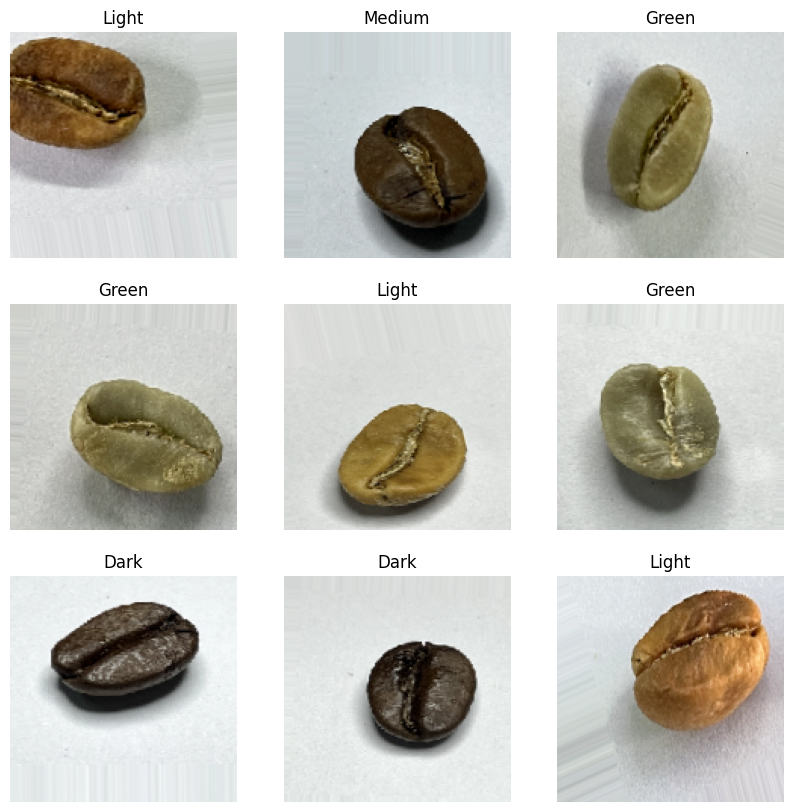

In [ ]:

# Get class indices from the training generator
class_indices = train_generator.class_indices

# Invert the dictionary for easier lookup of class names from indices
class_names = {v: k for k, v in class_indices.items()}

# Print class indices and names
print("Class Indices:")
print(class_indices)
print("\nClass Names:")
print(class_names)


# Function to plot images with class labels
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

# Example usage: Plot a few images from the training set
images, labels = next(train_generator)
plot_images(images, np.argmax(labels, axis=1), class_names)

**DATA AUGMENTATION**

 rotations, flips, zooms

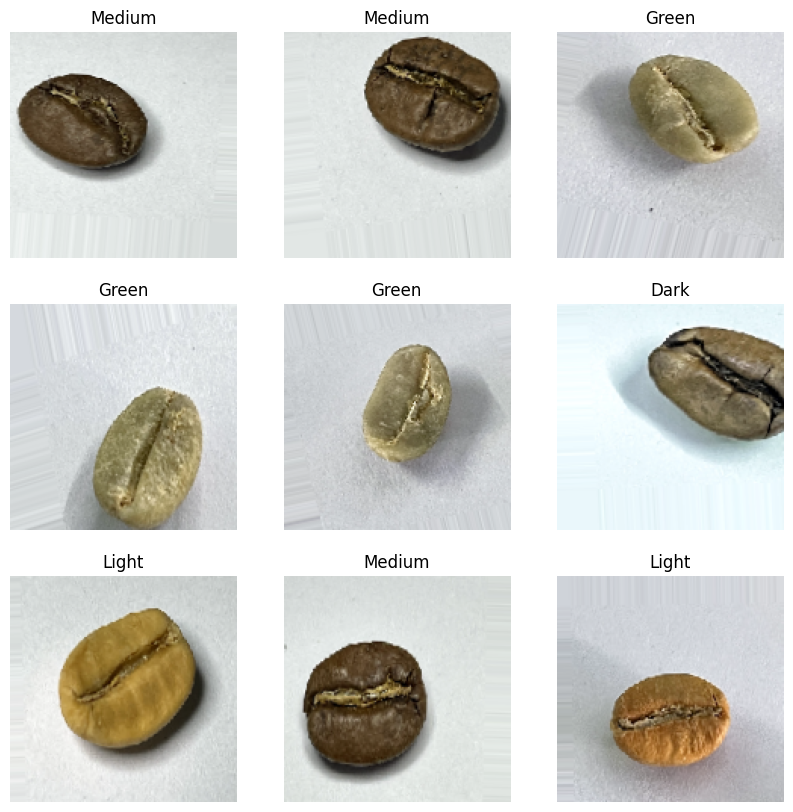

In [ ]:
# Get a batch of augmented images and labels
images, labels = next(train_generator)

# Function to plot augmented images with class labels
def plot_augmented_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Plot the first 9 augmented images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])  # Get the class name from the one-hot encoded labels
        plt.axis("off")
    plt.show()

# Plot augmented images
plot_augmented_images(images, labels, class_names)

**load pretrained denseNet model**

In [ ]:
# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Adjust the number of units as needed
predictions = Dense(len(class_names), activation='softmax')(x)  # Output layer with softmax for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model (optional, but often recommended)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 156, 156, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 38, 38, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 38, 38, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 38, 38, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 8,091,204 (30.87 MB)

 Trainable params: 1,053,700 (4.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Train the model**

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,  # Adjust the number of epochs as needed
    validation_data=test_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)] # Stop training if validation loss doesn't improve
)
# Save the model
model.save('/content/drive/MyDrive/Project/my_model.h5') # Save the model to your Google Drive
print("Model saved successfully")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 1130s 29s/step - accuracy: 0.5951 - loss: 1.8615 - val_accuracy: 0.9457 - val_loss: 0.1531
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.9515 - loss: 0.1405 - val_accuracy: 0.9704 - val_loss: 0.0738
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9645 - loss: 0.0941 - val_accuracy: 0.9605 - val_loss: 0.0857
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9673 - loss: 0.0880 - val_accuracy: 0.9827 - val_loss: 0.0576
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9684 - loss: 0.0914 - val_accuracy: 0.9901 - val_loss: 0.0342
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9689 - loss: 0.0875 - val_accuracy: 0.9630 - val_loss: 0.1001
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.9670 - loss: 0.0822 - val_accuracy: 0.9951 - val_loss: 0.0269
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9705 - loss: 0.0631 - val_accuracy: 0.9383 -

Model saved successfully


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


# Function to plot images with predictions
def plot_predictions(images, labels, predicted_labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()


# Get a batch of test images and labels
test_images, test_labels = next(test_generator)
true_labels = np.argmax(test_labels, axis=1)


# Plot the predictions
plot_predictions(test_images, true_labels, predicted_classes[:9], class_names)


# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_classes[:len(true_labels)])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import numpy as np
# Load the saved model
model = load_model('/content/drive/MyDrive/Project/my_model.h5')

image_path = '/content/drive/MyDrive/Project/test/Green/Green_0.jpg'

# Preprocess the image (resize and normalize)
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the pixel values

# Make the prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])

# Get the class name from the index
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class
print(f"The predicted class is: {predicted_class_name}")
